# Simplex

Simple simplex implementation for teaching about regression.

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
class Simplex:
    """
    Simplex minimizer for arbitrary 2D objective functions.
    """
    
    def __init__(self,objective_function,guess_min=-10,guess_max=10):
        """
        Create simplex instance.  
        
        arguments:
        ----------
        objective_function: objective function for the minimizer. must take x and
                            y as first arguments.
        guess_min: minimum initial guess (for both x and y)
        guess_max: maximum initial guess (for both x and y)
        """
        
        # Record objective function
        self._objective_function = objective_function

        # Create initial points as random raws from uniform distribution
        self.points = np.random.uniform(guess_min,guess_max,size=(3,2))
        
        # Record guesses
        self._guesses = np.copy(self.points)
        
        # Create values for points
        self._update_values()
        self._num_moves = 0
        self._plot = False
    
    
    def _update_values(self):
        """
        Calculate values and rank points from min to max.
        """
    
        self.values = [0,0,0]
        for i in range(3):
            self.values[i] = self._objective_function(*self.points[i,:])
            
        tmp = [(v,i) for i, v in enumerate(self.values)]
        tmp.sort()
        
        # points, from minimum to maximum
        self.min_pt = tmp[0][1]
        self.mid_pt = tmp[1][1]
        self.max_pt = tmp[2][1]
    
        
    def _flip(self):
        """
        Reflect maximum point across the midpoint between the other two points.
        """

        # midpoint for flipping
        mid_flip = self.points[self.min_pt,:] + (self.points[self.mid_pt,:] - self.points[self.min_pt,:])/2
        
        # move max point so its origin is the mid_flip point
        to_flip = self.points[self.max_pt,:] - mid_flip
        
        # Flip using some basic trig
        L = np.sqrt(np.sum(to_flip**2))
        thetax = np.arccos(to_flip[0]/L) + np.pi
        thetay = np.arcsin(to_flip[1]/L) + np.pi
        flipped = L*np.array((np.cos(thetax),np.sin(thetay)))
        
        # Move the flipped point back to the original coordinates
        new_point = flipped + mid_flip
        
        # Calculate value.  If it is no longer the max point, this is a successful move.
        new_value = self._objective_function(*new_point)
        if new_value < self.values[self.min_pt] or new_value < self.values[self.mid_pt]:
            
            # Plot if requested
            if self._plot:
                plt.plot((self.points[self.max_pt,0],new_point[0]),
                         (self.points[self.max_pt,1],new_point[1]),'y-')
                plt.plot((new_point[0]),(new_point[1]),"yo",ms=9)
            
            self.points[self.max_pt,:] = new_point            
            return True
        
        return False
    
    def _small_step(self):
        """
        Move the max point to midway between it and the midpoint between the other
        two points. 
        """
    
        # midpoint for flipping
        mid_flip = self.points[self.min_pt,:] + (self.points[self.mid_pt,:] - self.points[self.min_pt,:])/2
        
        # move max point so its origin is the mid_flip point
        to_flip = self.points[self.max_pt,:] - mid_flip
        
        # Move using some basic trig
        L = np.sqrt(np.sum(to_flip**2))
        thetax = np.arccos(to_flip[0]/L) + np.pi
        thetay = np.arcsin(to_flip[1]/L) + np.pi
        flipped = -0.5*L*np.array((np.cos(thetax),np.sin(thetay)))
        
        # Move the flipped point back to the original coordinates
        new_point = flipped + mid_flip
        
        # Calculate value.  If it is no longer the max point, this is a successful move
        new_value = self._objective_function(*new_point)
        if new_value < self.values[self.min_pt] or new_value < self.values[self.mid_pt]:
            
            # Plot if requested
            if self._plot:
                plt.plot((self.points[self.max_pt,0],new_point[0]),
                         (self.points[self.max_pt,1],new_point[1]),'y-',lw=2)
                plt.plot((new_point[0]),(new_point[1]),"yo",ms=9)
            
            self.points[self.max_pt,:] = new_point
            return True
        
        return False

    def _contract(self):
        """
        Contract the simplex towards the two better points.
        """
    
        # Plot starting triangle
        if self._plot:
            plt.plot(self.points[:,0],self.points[:,1],"ko",ms=6)
            plt.plot((self.points[self.min_pt,0],self.points[self.max_pt,0]),
                     (self.points[self.min_pt,1],self.points[self.max_pt,1]),"k-")
            plt.plot((self.points[self.mid_pt,0],self.points[self.max_pt,0]),
                     (self.points[self.mid_pt,1],self.points[self.max_pt,1]),"k-")
            plt.plot((self.points[self.min_pt,0],self.points[self.mid_pt,0]),
                     (self.points[self.min_pt,1],self.points[self.mid_pt,1]),"r--")
            
        # Midpoint between better two points
        mid_flip = self.points[self.min_pt,:] + (self.points[self.mid_pt,:] - self.points[self.min_pt,:])/2
        
        # Midpoint between the max and min points
        new_mid  = self.points[self.max_pt,:] + (self.points[self.min_pt,:] - self.points[self.max_pt,:])/2
                
        # Perform the contraction. 
        self.points[self.max_pt,:] = new_mid
        self.points[self.mid_pt,:] = mid_flip
        
        # Plot final triangle
        if self._plot:
            plt.plot(self.points[:,0],self.points[:,1],"yo",ms=6)
            plt.plot((self.points[self.min_pt,0],self.points[self.max_pt,0]),
                     (self.points[self.min_pt,1],self.points[self.max_pt,1]),"y-")
            plt.plot((self.points[self.mid_pt,0],self.points[self.max_pt,0]),
                     (self.points[self.mid_pt,1],self.points[self.max_pt,1]),"y-")
            plt.plot((self.points[self.min_pt,0],self.points[self.mid_pt,0]),
                     (self.points[self.min_pt,1],self.points[self.mid_pt,1]),"y-")
        
                
        return True
        
        
    def make_move(self,plot=False):
        """
        Make a simplex move.  Try flip, then small step, then contract.
        """
        
        self._plot = plot
        
        # Update to current values
        self._update_values()
        
        # Plot initial triangle
        if self._plot:
                
            plt.plot(self.points[:,0],self.points[:,1],"ko",ms=6)
            plt.plot((self.points[self.min_pt,0],self.points[self.max_pt,0]),
                     (self.points[self.min_pt,1],self.points[self.max_pt,1]),"k-")
            plt.plot((self.points[self.mid_pt,0],self.points[self.max_pt,0]),
                     (self.points[self.mid_pt,1],self.points[self.max_pt,1]),"k-")
            plt.plot((self.points[self.min_pt,0],self.points[self.mid_pt,0]),
                     (self.points[self.min_pt,1],self.points[self.mid_pt,1]),"r--")
    
        # If flip fails, small_step.  If small_step fails, contract. 
        if self._flip():
            print("flip")
        elif self._small_step():
            print("simple")
        else:
            print("large")
            self._contract()
            
        self._num_moves += 1
        
           
    def restore_guesses(self):
        """
        Restore the fitter to the initial guesses.
        """
        
        self.points = np.copy(self._guesses)
        
    @property
    def estimate(self):
        """
        Current best estimate of the minimum.
        """
        
        self._update_values()
 
        return self.points[self.min_pt], self.values[self.min_pt]
    

simple


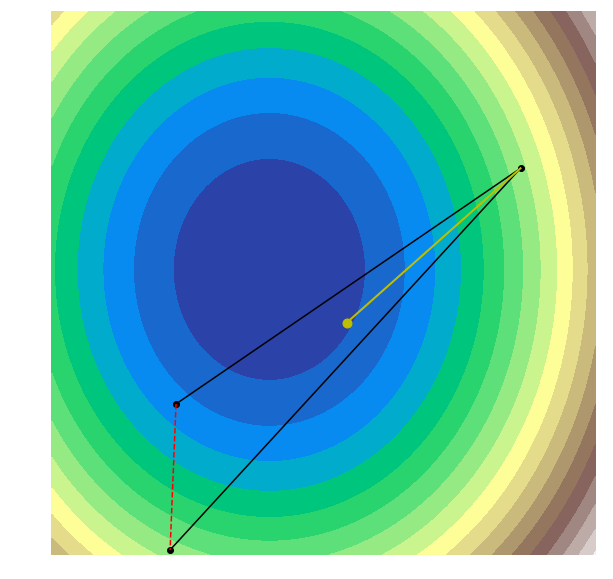

flip


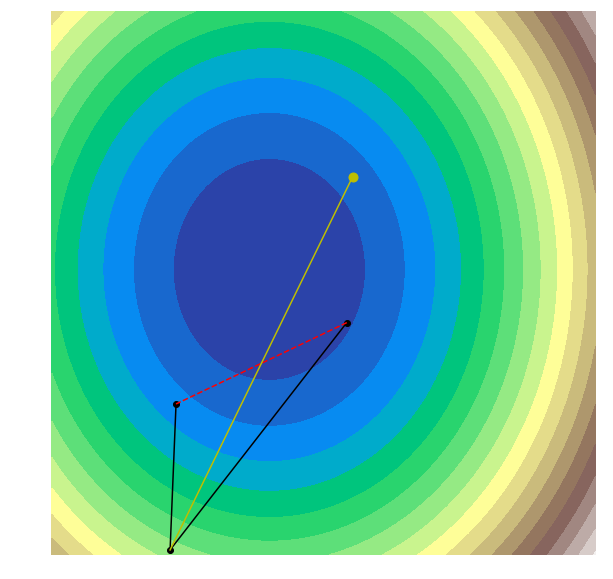

simple


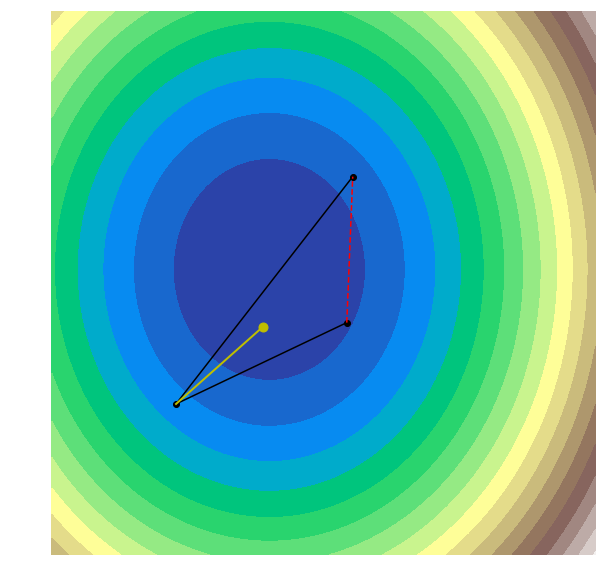

simple


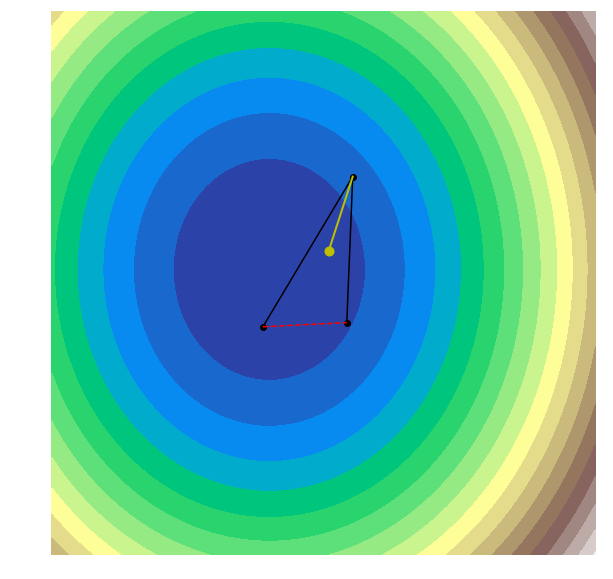

flip


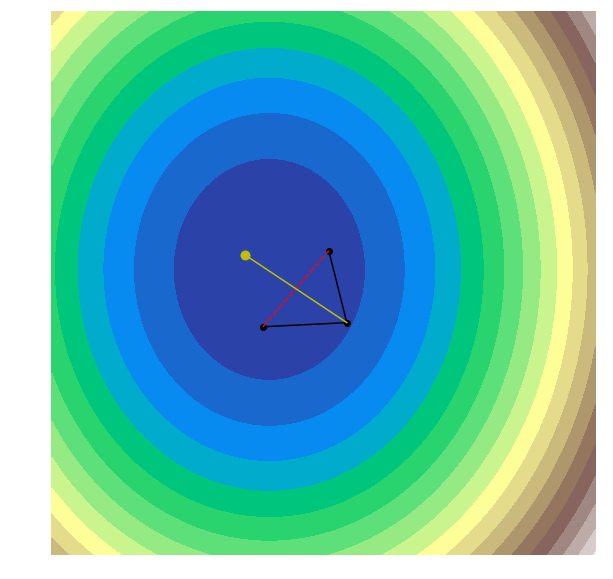

simple


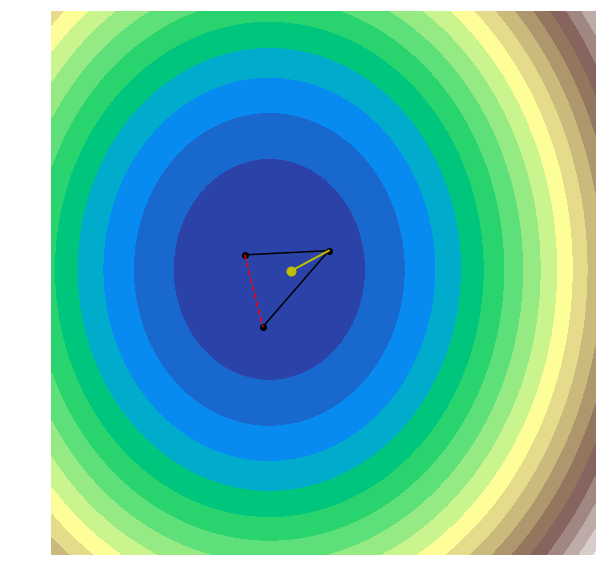

simple


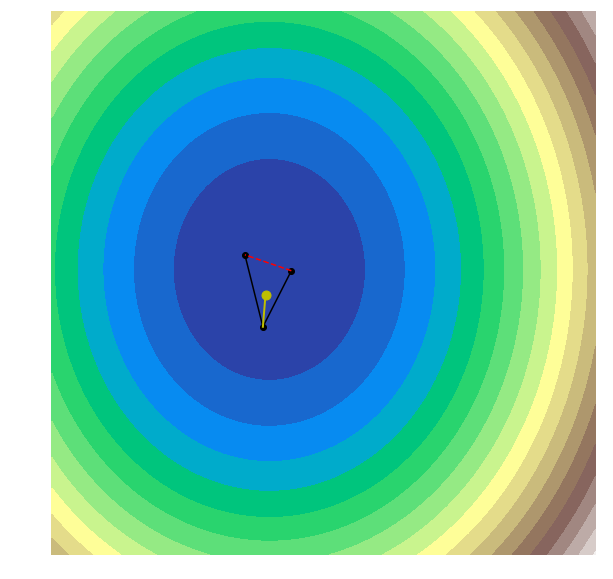

simple


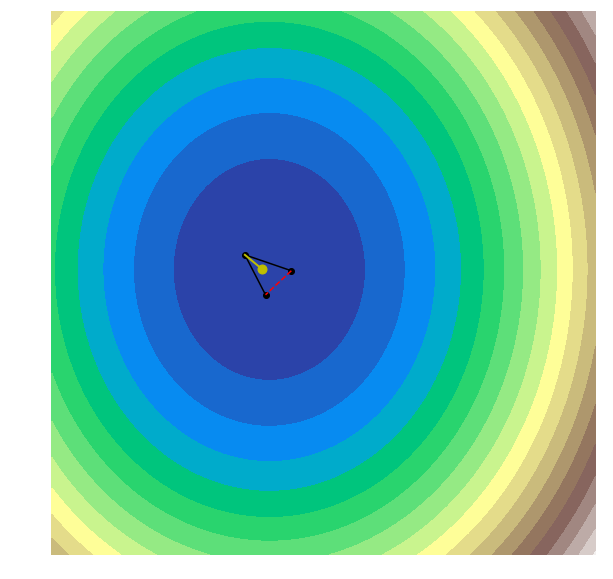

simple


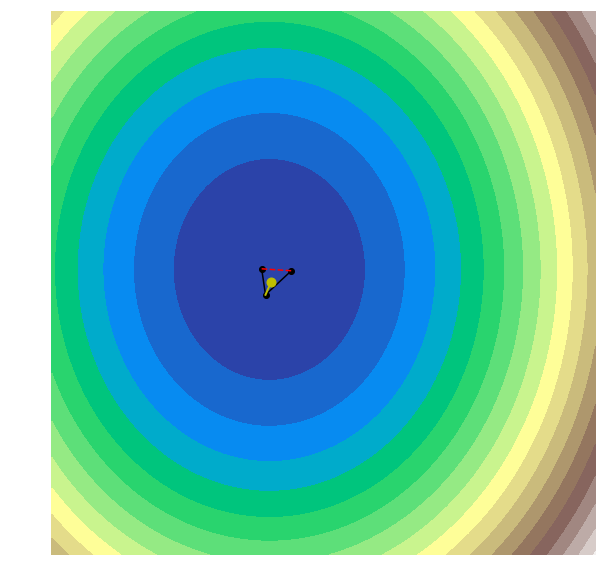

simple


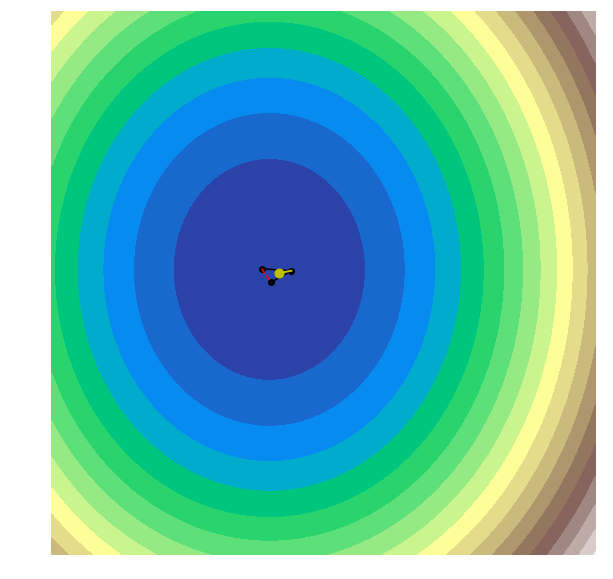

flip


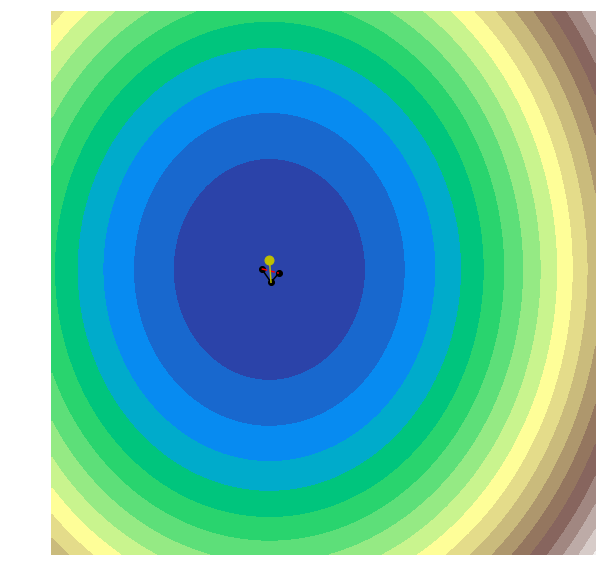

simple


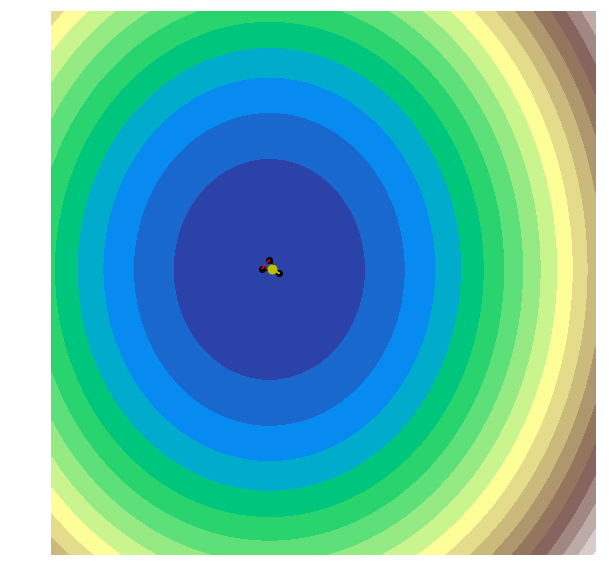

simple


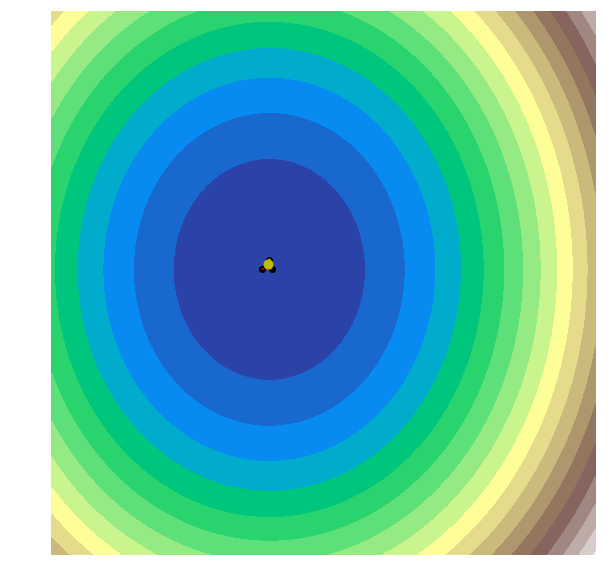

simple


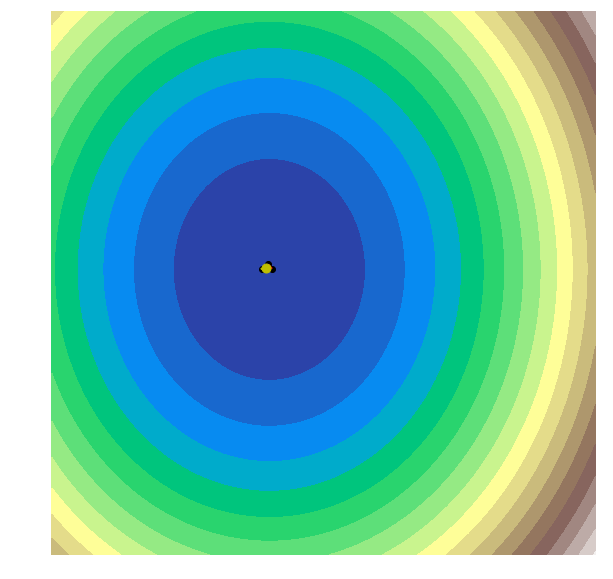

flip


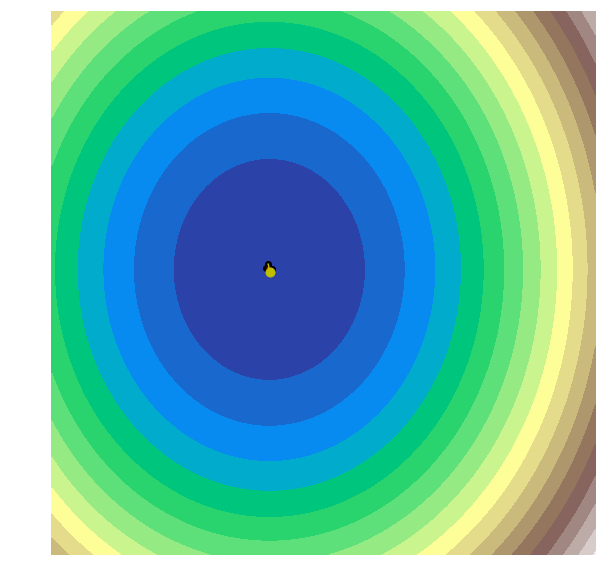

simple


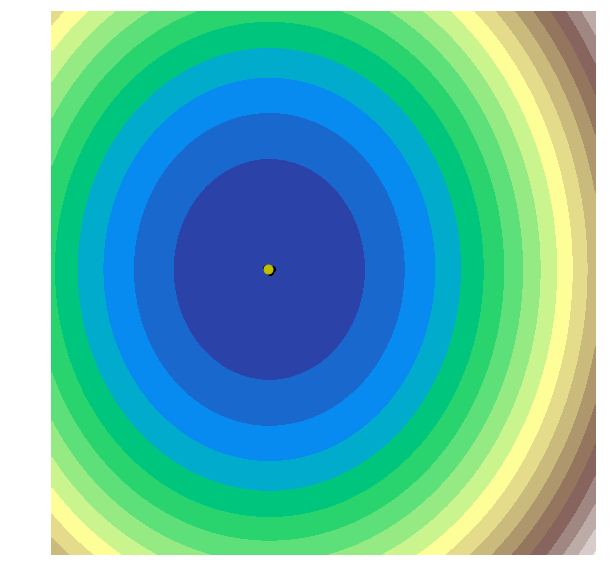

simple


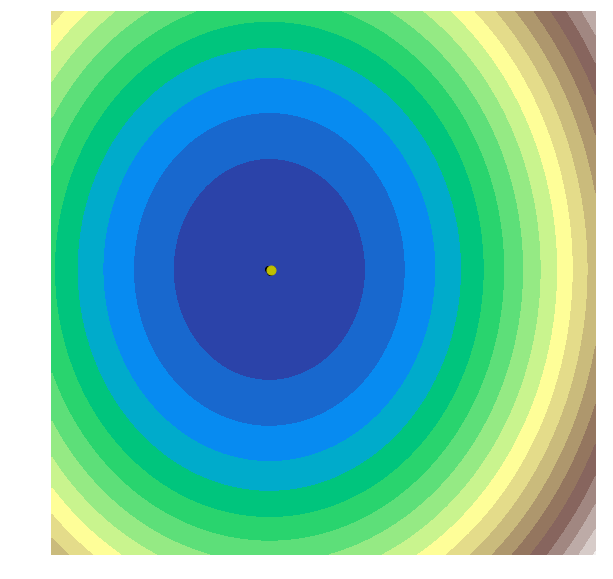

simple


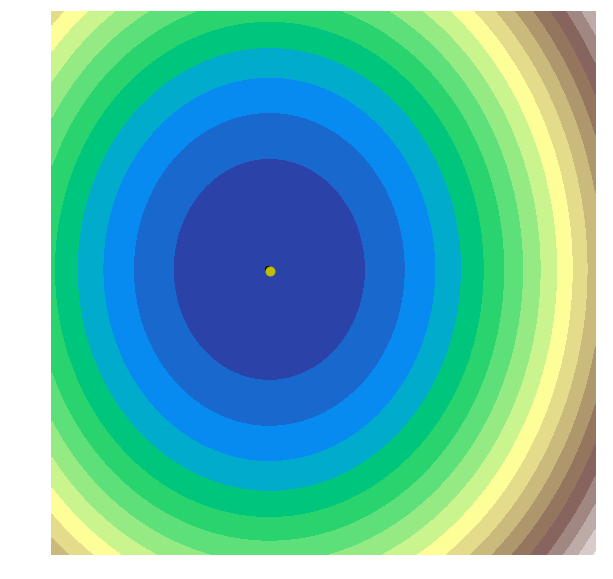

simple


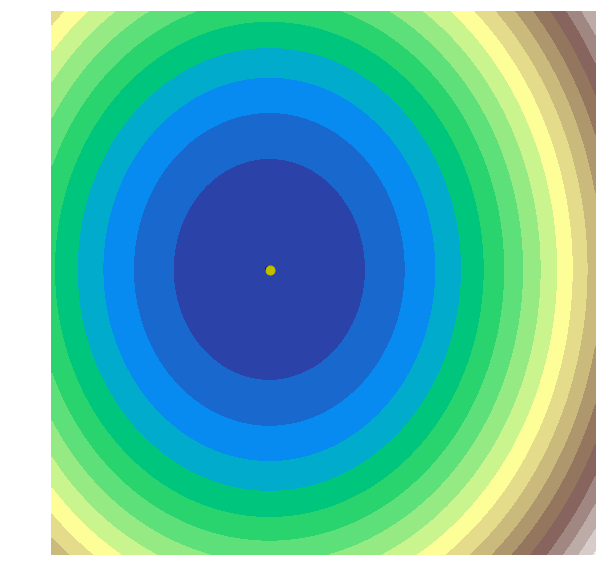

simple


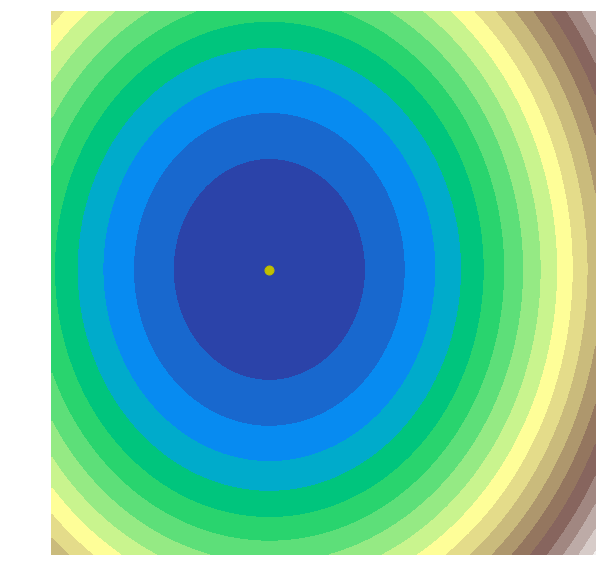

In [4]:

def objective_simple(x,y):
    """
    Single-peaked 2D polynomial in x and y.
    """
    
    return 20*(x + 2)**2 + 15*(y - 0.5)**2


def objective_doomed(x,y):
    """
    Saddle-shapped 2D polynomial in x and y.
    """
    
    return -20*(x + 2)**2 + 15*(y - 0.5)**2


def objective_multi(x,y):

    return -(20*(x + 5))**2 - (20*(y + 5))**2 + (20*(x - 5))**2 + (20*(y - 5))**2


def run_simplex(objective_function,prefix="z",simplex=None,figsize=(10,10)):


    if simplex == None:
         simplex = Simplex(objective_function)


    xlist = np.linspace(-10.0, 10.0, 100)
    ylist = np.linspace(-10.0, 10.0, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = objective_function(X,Y)

    for i in range(20):

        plt.figure(figsize=figsize)
        cp = plt.contourf(X, Y, Z,20,cmap="terrain")

        #plt.plot((-2),(0.5),"b+",ms=10)
        plt.axis("equal")
        plt.axis("off")
        plt.xlim((-10,10))
        plt.ylim((-10,10))

        simplex.make_move(plot=True)
        #simplex.make_move(plot=False)
        
        name = "{}".format(i)
        name = name.zfill(5)
        plt.savefig("{}{}.png".format(prefix,name),bbox_inches="tight")
        plt.show()
        
    return simplex

#s.restore_guesses()
x = run_simplex(objective_simple)



# Prep: Create a m/b SSR heat map

In [ ]:
m_list = np.linspace(-0.5, 0.5, 100)
b_list = np.linspace(-0.5, 0.5, 100)
M, B = np.meshgrid(m_list,b_list)

def ssr(x_obs,y_obs,m,b):
    
    out = np.zeros(m.shape)    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            out[i,j] = np.sum(((m[i,j]*x_obs + b[i,j]) - y_obs)**2)
    
    return out

Z = ssr(d.time,d.obs,M,B)

plt.figure(figsize=(8,8))
cp = plt.contourf(M, B, Z,20,cmap="terrain")
plt.axis("equal")
plt.xlabel("m")
plt.ylabel("b")

plt.plot((0.0696240601504),(0.186085714286),"y+",ms=20)

plt.savefig("param-space.png")

##  Regression engine

In [ ]:
## Models

def lin(x,a=1,b=1):
    return a + b*x

def hb(x,a=1,b=1):
    return a*(b*x)/(1 + b*x)

def hbc(x,a=1,b=1,c=1):
    return a*(b*(x**c))/(1 + b*(x**c))

def expt(x,a=1,b=1):
    return a*(1 - np.exp(-b*x))

def second(x,a=1,b=1,c=1):
    return a + b*x + c*(x**2)

def third(x,a=1,b=1,c=1,d=1):
    return a + b*x + c*(x**2) + d*(x**3)

def trig(x,a=1,b=1,c=1):
    return a*np.sin(b*x + c)

def trig2(x,a=1,b=1,c=1,d=1):
    return a*np.sin(x*b) + c*np.sin(x*d)

def logd(x,a=1,b=1):
    
    return a*np.log(x + b)

def logdc(x,a=1,b=1,c=1):
    
    return a*np.log(x*b + c

In [ ]:
### TEST FITTING

import inspect

def residuals(param,x,y,f):
    """A generalized residuals function."""
    return y - f(x,*param)

def fitter(x,y,f):
    """
    A generalized fitter.  Find parameters of `f` that minimize the 
    residual between `f` and `y` for values of `x`.  This function
    assumes that `f` has the form:
    
    f(x,param1,param2,param3...)
    
    x and y should be numpy arrays of the same length.
    """
    
    # Create a list of parameter names and guesses using `inspect`
    names = []
    guesses = []
    s = inspect.signature(f)
    for i, p in enumerate(s.parameters):
        names.append(s.parameters[p].name)
        guesses.append(s.parameters[p].default)
    
    # Fit the model to the data.
    x0 = np.array(guesses[1:])
    fit = scipy.optimize.least_squares(residuals,x0,
                                       args=(x,y,f))

    
    # Plot hte fit
    x_range = np.linspace(np.min(x),np.max(x),100)
    plt.plot(x_range,f(x_range,*fit.x),"-")
    
    # Calculate R^2
    ss_err = np.sum(residuals(fit.x,x,y,f)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    R_sq = 1 - (ss_err/ss_tot)
    
    return len(fit.x), np.sum(residuals(fit.x,x,y,f)**2)
    
# Load in dataset
d = pd.read_csv("dataset_0.csv")
plt.plot(d.x,d.y,"ko")

# Fit all of those functions to the data
func_list = [lin,hb,hbc,expt,second,third,trig,trig2,logd,logdc]
results = []
for f in func_list:
    results.append((str(f).split()[1],fitter(d.x,d.y,f)))
    print(results[-1])

# Generate data sets to fit

In [ ]:
# Generate data
        
x = np.linspace(0,10,41)
y = expt(x,4,0.3) + np.random.normal(0,0.3,len(x))

d = pd.DataFrame({"x":x,"y":y})
plt.plot(x,y,"o"); plt.show()
d.to_csv("dataset_0.csv")

In [ ]:
x = np.linspace(0,10,41)
y = hbc(x,4,0.005,4) + np.random.normal(0,0.3,len(x))

d = pd.DataFrame({"x":x,"y":y})
plt.plot(x,y,"o"); plt.show()
d.to_csv("dataset_1.csv")